<div class="alert alert-block alert-info">
    
These blue boxes contain instructions for you to follow, or stuff for you to do
<h2>How to access this Jupyter notebook</h2>

* <b>Step 1</b>: Open a web browser,  and go to [this page](https://jupyter.warwick.ac.uk/module/CH274), 
* <b>Step 2</b>: Enter your SCRTP username and password and press the "Start Server" button.<br>
* <b>Step 3</b>: Wait (it could take a few minutes) until the blue box says "Jupyter notebook server running!". At that point, click on the weblink below said message.<br>
* <b>Step 4</b>: Select the Jupyter Notebook you want to work on. <i>Remember to make a copy of the orginal notebook</i> (which is read-only). To do so, in the toolbar on top of the notebook, select File and then Make a Copy <br>
* <b>Step 5</b>: You're all set! <br>
* <b>Step 6</b>: <font color="red">When you are done, remember to click the "Stop Server" button in the launcher web browser tab.</font> Please do, it's really quite important. <br>
<b> Remember: </b> You can access your copy of the Notebook at any time from any device off and on campus by going through the same steps on e.g. your laptop - all the changes you have made will be saved and synced! <br>

<div/>

In [1]:
import fileinput
import re
import glob

def grep(PAT, FILES,index):
    energies=[]
    fileinput.close()
    for line in fileinput.input(glob.glob(FILES)):
        if re.search(PAT, line):
            energies.append(float(line.split()[index]))
    return energies

In [2]:
#Import necessary modules
import numpy as np
import matplotlib.pyplot as plt
import psi4
import ase
from ase.build import molecule
from ase.atoms import Atoms
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from psi4_helper import geom_ase_to_psi4

# Excited states of NaI

In the second part of this exercise, the focus will be on excited states. Excited states play a significant role in photochemistry. As you have heard in the previous tutorial, calculation of excited states and their properties requires different methods than for the ground state chemistry. For the excited states, the approximation of only one Slater determinant is usually not valid. Unlike Hartree-Fock, multiconfigurational methods do not restrict the wavefunction to a single Slater determinant, but allow it to be a priori a linear combination of multiple Slater determinants.
On the other hand, a handful of methods usually referred to single-configurational methods, such as TD-DFT can be used to compute the excited-state properties without calculating the excited state wavefunction explicitly. They are faster and easier to use than multiconfigurational methods, but their accuracy may be inferior.

In this exercise we will calculate the excitation energies of the dissociation curve of the sodium iodide (NaI).
This system has been studied via pump-probe spectroscopy by Ahmed Zewail, who received the Nobel Prize for his work in 1999 (J. Chem. Phys. 91, 7415 (1989), doi: 10.1063/1.457266). You will see that the ground state and the first excited singlet state will form an avoided crossing. We will investigate this reaction with TDDFT and CASSCF.


</div>
<img src="NaI2.png" width="350"/>
</div>
<p> Potential energy curves of NaI (Fig. 2 in Ref. 4).</p>


In [3]:
# Prepare the geometries

# we set the positions to 0 for atom 0 and to 2-6.0 for atom 2
all_atoms = []
nsteps=20
positions=np.zeros((2,3))
atomtype = ["Na","I"]
dr=(6-2)/nsteps
all_distances = np.zeros((nsteps,1))
for i in range(nsteps):
    positions[1,2]=2+i*dr
    all_distances[i]=2+i*dr
    atoms = ase.atoms.Atoms(atomtype,positions)
    all_atoms.append(atoms)
#print(all_atoms[1].positions,all_atoms[2].positions)

### CASSCF calculation of the excited states

NaI has 64 electrons
if we want to describe only the $\sigma$ and $\sigma^\ast$ orbitals, then we need 2 electrons in 2 orbitals.
Hence we have:
* 62 electrons sit in 31 orbitals that are doubly occupied and inactive
* orbital number 63 and 64 are active and contain all possible configurations of that 2 electrons can form (how many are these?)
* orbitals above 65 are inactive and unoccupied.

In [4]:
#casscf test
import psi4
psi4.core.clean_options()
psi4.set_memory('2 GB');
n_states = 3
psi4.set_options({
    'basis': 'sto-3g',
    'reference': 'rhf',
    'scf_type':'pk',
    'mcscf_algorithm':'ah',
    'qc_module': 'detci',
    'nat_orbs': True,
    'num_roots':n_states,
    'frozen_docc': [31],
    'active': [2],
    'mcscf_diis_start':35,
    'maxiter':300

})
energies_casscf = np.zeros((nsteps,n_states)) 
for step in range(nsteps):
    geom_input = geom_ase_to_psi4(all_atoms[step], charge=0, multiplicity=1)
    psi4.core.set_output_file("NaI%i.out"%step)

    #initiate Psi4 molecule object
    nai = psi4.geometry(geom_input)
    try:
        casscf_energy, wfn = psi4.energy('casscf', return_wfn=True)
        energy = grep("MCSCF Root","NaI%i.out"%step,5)
        energies_casscf[step]=energy
    except:
        pass

    

(0.0, 2.0)

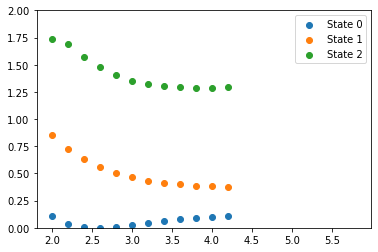

In [7]:
minimum=np.min(energies_casscf[:10])
for i in range(3):
    plt.scatter(all_distances,energies_casscf[:,i]-minimum,label="State %i"%i)
plt.legend()
plt.ylim(0,2)

As you can see, the accuracy of CASSCF could definitely be improved by a larger basis set or a larger active space. This calculation is, however, quite expensive, such that this notebook cannot handle it anymore.
Further, it would be good to calculate larer bond distances, but with the current wave function, it's had to get the MCSCF converged.

we will compare to <b> CCSD<b>, which can also do excited-state calculations: 

### CCSD
We will extend the geometries to larger bond distances (CASSCF wave function fails to converge with current settings)

In [8]:
#Make more geometries
# we set the positions to 0 for atom 0 and to 0.5-4.0 for atom 2
all_atoms = []
nsteps=20
positions=np.zeros((2,3))
atomtype = ["Na","I"]
dr=(6-2)/nsteps
all_distances = np.zeros((nsteps,1))
for i in range(nsteps):
    positions[1,2]=2+i*dr
    all_distances[i]=2+i*dr
    atoms = ase.atoms.Atoms(atomtype,positions)
    all_atoms.append(atoms)
#print(all_atoms[1].positions,all_atoms[2].positions)


In [11]:
psi4.core.clean_options()
n_states = 3
psi4.set_memory('2 GB')
psi4.set_options({
    'basis': 'sto-3g',
    'reference': 'rhf',
    'scf_type':'pk',
    'roots_per_irrep': [n_states],
    'maxiter': 150
})
energies_cc = []# np.zeros((nsteps,n_states)) 
for step in range(nsteps):
    geom_input = geom_ase_to_psi4(all_atoms[step], charge=0, multiplicity=1)
    psi4.core.set_output_file("NaI%i_CC.out"%step)

    #initiate Psi4 molecule object
    nai = psi4.geometry(geom_input)
    if step == 0:
        energy,wfn=psi4.energy("eom-ccsd",return_wfn=True)
    else:
        energy,wfn=psi4.energy("eom-ccsd",return_wfn=True)#,wfn_guess=wfn)
    energy_cc = grep("EOM State","NaI%i_CC.out"%step,6)
    energies_cc.append(energy_cc)
    


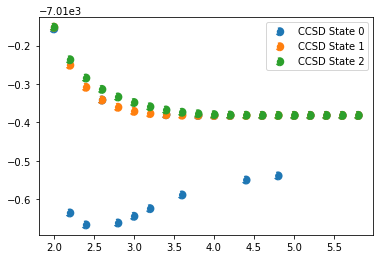

In [12]:
energies_cc=np.array(energies_cc)
for i in range(3):
    plt.scatter(all_distances,energies_cc[:,i],label="CCSD State %i"%i,linewidth=3,linestyle="--")
plt.legend()
plt.legend()

This is also a very nice example of a calculation that fails.
Such jumps in the potential energy curves are very common in excited-state simulations and complicate any fitting process that might be powerful for ground-state problems and systems with little correlation.

### TASK

Play around and try to find settings that give qualitatively correct results.
You can either alter the active space or convergence criteria in CASSCF, change the basis set (see here for basis sets for iodine: https://psicode.org/psi4manual/master/basissets_byelement.html#apdx-basiselement), change settings in CCSD or try different methods, such as TDDFT.

<b> How would you perform a doublet, triplet, etc. state calculation instead of singlet excited state calculation? What do you need to change in your input? <b>

## References
1. [[Szabo:1996](http://store.doverpublications.com/0486691861.html)] A. Szabo and N. S. Ostlund, *Modern Quantum Chemistry*, Introduction to Advanced Electronic Structure Theory. Courier Corporation, 1996.
2. [[Levine:2000](https://books.google.com/books?id=80RpQgAACAAJ&dq=levine%20quantum%20chemistry%205th%20edition&source=gbs_book_other_versions)] I. N. Levine, *Quantum Chemistry*. Prentice-Hall, New Jersey, 5th edition, 2000.
3. [[Helgaker:2000](https://books.google.com/books?id=lNVLBAAAQBAJ&pg=PT1067&dq=helgaker+molecular+electronic+structure+theory&hl=en&sa=X&ved=0ahUKEwj37I7MkofUAhWG5SYKHaoPAAkQ6AEIKDAA#v=onepage&q=helgaker%20molecular%20electronic%20structure%20theory&f=false)] T. Helgaker, P. Jorgensen, and J. Olsen, *Molecular Electronic Structure Theory*, John Wiley & Sons Inc, 2000.
4. J. Chem. Phys. 91, 7415 (1989), doi: 10.1063/1.457266